In [1]:
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
import numpy as np
import torch
import gc
from tqdm import tqdm
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import pickle
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
data_format1_path = "data_format1"
data_format2_path = "data_format2"
train_format1_path = os.path.join(data_format1_path, "train_format1.csv")
train_format2_path = os.path.join(data_format2_path, "train_format2.csv")
test_format1_path = os.path.join(data_format1_path, "test_format1.csv")
test_format2_path = os.path.join(data_format2_path, "test_format2.csv")
user_info_format1_path = os.path.join(data_format1_path, "user_info_format1.csv") 
user_log_format1_path = os.path.join(data_format1_path, "user_log_format1.csv", ) 

In [5]:
train_format1 = pd.read_csv(train_format1_path)
#train_format2 = pd.read_csv(train_format2_path)
test_format1 = pd.read_csv(test_format1_path)
#test_format2 = pd.read_csv(test_format2_path)
user_info_format1 = pd.read_csv(user_info_format1_path)
user_log_format1 = pd.read_csv(user_log_format1_path, dtype={'time_stamp': str}).rename(columns={"seller_id": "merchant_id"})

In [32]:
print("User id amount", len(set(train_format1["user_id"].unique()).union(set(test_format1["user_id"].unique()))))
print("Brand id amount", len(set(user_log_format1["brand_id"].unique())))
print("Merchant id amount", len(set(train_format1["merchant_id"].unique()).union(set(test_format1["merchant_id"].unique()))))
print("Cat id amount", len(set(user_log_format1["cat_id"].unique())))

User id amount 424170
Brand id amount 8444
Merchant id amount 1994
Cat id amount 1658


In [4]:
print("len train_format1:", len(train_format1))
#print("len train_format2:", len(train_format2))
print("len test_format1:", len(test_format1))
#print("len test_format2:", len(test_format2))

len train_format1: 260864
len test_format1: 261477


In [5]:
print(len(user_log_format1))
#only filter the log with time_stamp 11.11
user_log_format1 = user_log_format1[user_log_format1["time_stamp"] == "1111"]
print(len(user_log_format1))

54925330
10582633


In [6]:
print(user_log_format1.head())

     user_id  item_id  cat_id  merchant_id  brand_id time_stamp  action_type
171   328862   406349    1280         2700    5476.0       1111            0
172   328862   406349    1280         2700    5476.0       1111            0
173   328862   807126    1181         1963    6109.0       1111            0
174   328862   406349    1280         2700    5476.0       1111            2
175   328862   406349    1280         2700    5476.0       1111            0


In [7]:
user_log_format1 = user_log_format1.drop(columns=["action_type", "time_stamp"])

In [8]:
print("user_log_info1 columns: " + str(user_log_format1.columns))

user_log_info1 columns: Index(['user_id', 'item_id', 'cat_id', 'merchant_id', 'brand_id'], dtype='object')


In [9]:
print(train_format1.head())
print("============================================")
print(train_format1.describe())
print("============================================")
#check for nan
print(train_format1.isnull().sum())
#nan ratio
print(train_format1.isnull().sum()/len(train_format1))

   user_id  merchant_id  label
0    34176         3906      0
1    34176          121      0
2    34176         4356      1
3    34176         2217      0
4   230784         4818      0
             user_id    merchant_id          label
count  260864.000000  260864.000000  260864.000000
mean   211889.321420    2540.292363       0.061151
std    122399.488027    1451.207514       0.239607
min         1.000000       2.000000       0.000000
25%    105488.000000    1340.000000       0.000000
50%    211927.500000    2482.000000       0.000000
75%    317670.500000    3898.000000       0.000000
max    424170.000000    4993.000000       1.000000
user_id        0
merchant_id    0
label          0
dtype: int64
user_id        0.0
merchant_id    0.0
label          0.0
dtype: float64


In [10]:
# print(train_format2.head())
# print("============================================")
# print(train_format2.describe())
# print("============================================")
# #check for nan
# print(train_format2.isnull().sum())
# #nan ratio
# print(train_format2.isnull().sum()/len(train_format2))

In [11]:
print(test_format1.head())
print("============================================")
test_format1.describe()
print("============================================")
print(test_format1.isnull().sum())
print(test_format1.isnull().sum()/len(test_format1))

   user_id  merchant_id  prob
0   163968         4605   NaN
1   360576         1581   NaN
2    98688         1964   NaN
3    98688         3645   NaN
4   295296         3361   NaN
user_id             0
merchant_id         0
prob           261477
dtype: int64
user_id        0.0
merchant_id    0.0
prob           1.0
dtype: float64


In [12]:
# print(test_format2.head())
# print("============================================")
# test_format2.describe()
# print("============================================")
# print(test_format2.isnull().sum())
# print(test_format2.isnull().sum()/len(test_format2))

In [13]:
print(user_info_format1.head())
print("============================================")
print(user_info_format1.describe())
print("============================================")
print(user_info_format1.isnull().sum())
print(user_info_format1.isnull().sum()/len(user_info_format1))

   user_id  age_range  gender
0   376517        6.0     1.0
1   234512        5.0     0.0
2   344532        5.0     0.0
3   186135        5.0     0.0
4    30230        5.0     0.0
             user_id      age_range         gender
count  424170.000000  421953.000000  417734.000000
mean   212085.500000       2.930262       0.341179
std    122447.476179       1.942978       0.524112
min         1.000000       0.000000       0.000000
25%    106043.250000       2.000000       0.000000
50%    212085.500000       3.000000       0.000000
75%    318127.750000       4.000000       1.000000
max    424170.000000       8.000000       2.000000
user_id         0
age_range    2217
gender       6436
dtype: int64
user_id      0.000000
age_range    0.005227
gender       0.015173
dtype: float64


In [14]:
print(user_log_format1.head())
print("============================================")
print(user_log_format1.describe())
print("============================================")
print(user_log_format1.isnull().sum())
print(user_log_format1.isnull().sum()/len(user_log_format1))

     user_id  item_id  cat_id  merchant_id  brand_id
171   328862   406349    1280         2700    5476.0
172   328862   406349    1280         2700    5476.0
173   328862   807126    1181         1963    6109.0
174   328862   406349    1280         2700    5476.0
175   328862   406349    1280         2700    5476.0


            user_id       item_id        cat_id   merchant_id      brand_id
count  1.058263e+07  1.058263e+07  1.058263e+07  1.058263e+07  1.056487e+07
mean   2.123082e+05  5.477336e+05  8.938849e+02  2.408522e+03  4.079078e+03
std    1.222255e+05  3.246887e+05  4.371969e+02  1.512776e+03  2.422199e+03
min    1.000000e+00  2.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
25%    1.067360e+05  2.608150e+05  6.020000e+02  1.087000e+03  1.866000e+03
50%    2.125260e+05  5.544080e+05  9.460000e+02  2.387000e+03  3.969000e+03
75%    3.179590e+05  8.225780e+05  1.238000e+03  3.760000e+03  6.143000e+03
max    4.241700e+05  1.113166e+06  1.671000e+03  4.995000e+03  8.477000e+03
user_id            0
item_id            0
cat_id             0
merchant_id        0
brand_id       17767
dtype: int64
user_id        0.000000
item_id        0.000000
cat_id         0.000000
merchant_id    0.000000
brand_id       0.001679
dtype: float64


In [15]:
# does there exist user_id and merchant_id pair that appears in test set
print(pd.merge(train_format1[["user_id", "merchant_id"]].drop_duplicates(), test_format1[["user_id", "merchant_id"]].drop_duplicates(), how="inner", on=["user_id", "merchant_id"]))
print(pd.merge(train_format1[["user_id", "merchant_id"]].drop_duplicates(), test_format1[["user_id", "merchant_id"]].drop_duplicates(), how="inner", on=["user_id"]))
print(pd.merge(train_format1[["user_id", "merchant_id"]].drop_duplicates(), test_format1[["user_id", "merchant_id"]].drop_duplicates(), how="inner", on=["merchant_id"]))

Empty DataFrame
Columns: [user_id, merchant_id]
Index: []


Empty DataFrame
Columns: [user_id, merchant_id_x, merchant_id_y]
Index: []
           user_id_x  merchant_id  user_id_y
0              34176         3906     325008
1              34176         3906     282768
2              34176         3906     187542
3              34176         3906      97206
4              34176         3906     153795
...              ...          ...        ...
150064189     229247         4140     188243
150064190     229247         4140     171110
150064191     229247         4140     238697
150064192     229247         4140     176240
150064193     229247         4140     333428

[150064194 rows x 3 columns]


In [16]:
print(user_log_format1[user_log_format1["user_id"] == 360576])

         user_id  item_id  cat_id  merchant_id  brand_id
4930955   360576   991507    1142         4044      82.0
4930956   360576   948181     614         1581    4066.0
4930958   360576  1111020     614         1581    4066.0
4930959   360576   755622     614         1783    5041.0
4930960   360576   294442     614         1581    4066.0
4930961   360576   864510     614         1581    4066.0
4930962   360576   326679     614         1581    4066.0
4930963   360576   720542     748         2582    7208.0
4930964   360576   755622     614         1783    5041.0
4930967   360576   794107     614         1581    4066.0
4930969   360576   864510     614         1581    4066.0
4930970   360576   755622     614         1783    5041.0
4930971   360576   755622     614         1783    5041.0
4930973   360576   982117     632         1581    4066.0
4930974   360576    61318     229         1581    4066.0
4930975   360576   164776     389         3848    4452.0
4930976   360576  1091811    11

In [17]:
test_format1[~test_format1['user_id'].isin(user_log_format1['user_id'])]

,user_id,merchant_id,prob


In [18]:
#verify user activity of test users all exist inside the data
missing_keys = test_format1[~test_format1[['user_id', 'merchant_id']].isin(user_log_format1[['user_id', 'merchant_id']])]
missing_keys_user_only = test_format1[~test_format1['user_id'].isin(user_log_format1['user_id'])]
missing_keys_merchant_only = test_format1[~test_format1[ 'merchant_id'].isin(user_log_format1['merchant_id'])]
print("Original test length: ", len(test_format1))
print("User merchant pair in test not appear in log: ", len(missing_keys.drop_duplicates()))
print("User in test not appear in log: ", len(missing_keys_user_only.drop_duplicates()))
print("merchant in test not appear in log: ", len(missing_keys_merchant_only.drop_duplicates()))

Original test length:  261477
User merchant pair in test not appear in log:  261477
User in test not appear in log:  0
merchant in test not appear in log:  0


In [19]:
#unique value of user id
train_format1['user_id'].nunique()
print("Train user id Uniqueness ratio: ", train_format1['user_id'].nunique() / len(train_format1['user_id']))
print("Test user id Uniqueness ratio: ", test_format1['user_id'].nunique() / len(test_format1['user_id']))

print("Train merchant id Uniqueness ratio: ", train_format1['merchant_id'].nunique() / len(train_format1['merchant_id']))
print("Test merchant Uniqueness ratio: ", test_format1['merchant_id'].nunique() / len(test_format1['merchant_id']))

Train user id Uniqueness ratio:  0.8129216756624141
Test user id Uniqueness ratio:  0.8111918065451263
Train merchant id Uniqueness ratio:  0.007639996319921492
Test merchant Uniqueness ratio:  0.007622085307694367


In [20]:
#duplicate data in train_format1 between merchant and user id
print("Amount of user id and merchant id duplicated in train: ", train_format1[['user_id', 'merchant_id']].duplicated().sum())
print("Amount of user id and merchant id duplicated in test: ",test_format1[['user_id', 'merchant_id']].duplicated().sum())

Amount of user id and merchant id duplicated in train:  0
Amount of user id and merchant id duplicated in test:  0


In [21]:
#check if all label -1 in format_2 is all contains in user_log format 1
# tmp = test_format2[test_format2["label"] == -1][["user_id", "merchant_id"]]
# mask = tmp.isin(user_log_format1[["user_id", "merchant_id"]]).all(axis=1)
# print("total of merchant and user in test format 2: ", len(tmp))
# print("======= Mask ==========")
# print(mask)
# print("Amount that is contained in format1: ", len(tmp[mask]))
# del tmp

In [6]:
#join the tables
train_format1 = pd.merge(train_format1, user_log_format1, on=['user_id', 'merchant_id'], how='left')
print(train_format1.head())
print("====")
test_format1 = pd.merge(test_format1, user_log_format1, on=['user_id', 'merchant_id'], how='left')
print(test_format1.head())
print("====")
train_format1 = pd.merge(train_format1, user_info_format1, on='user_id', how='left')
print(train_format1.head())
print("====")
test_format1 = pd.merge(test_format1, user_info_format1, on='user_id', how='left')
print(test_format1.head())
print("====")

   user_id  merchant_id  label  item_id  cat_id  brand_id time_stamp  \
0    34176         3906      0   757713     821    6268.0       1110   
1    34176         3906      0   757713     821    6268.0       1110   
2    34176         3906      0   757713     821    6268.0       1110   
3    34176         3906      0   718096    1142    6268.0       1031   
4    34176         3906      0   757713     821    6268.0       1031   

   action_type  
0            0  
1            0  
2            0  
3            3  
4            3  
====
   user_id  merchant_id  prob  item_id  cat_id  brand_id time_stamp  \
0   163968         4605   NaN   772645    1368    7622.0       1111   
1   163968         4605   NaN   772645    1368    7622.0       1111   
2   360576         1581   NaN   948181     614    4066.0       1111   
3   360576         1581   NaN  1111020     614    4066.0       1111   
4   360576         1581   NaN   294442     614    4066.0       1111   

   action_type  
0            2  

In [24]:
print(len(train_format1))
print(len(test_format1))

1653030
1650271


In [25]:
# are all users and merchant in tests appear in trains
print("Test user id not in train: ", len(set(test_format1['user_id']) - set(train_format1['user_id'])))
print("Test user id not in log", len(set(test_format1['user_id']) - set(user_log_format1['user_id'])))
print("Test merchant id not in log: ", len(set(test_format1['merchant_id']) - set(user_log_format1['merchant_id'])))
print("Test merchant id not in train: ", len(set(test_format1['merchant_id']) - set(train_format1['merchant_id'])))
print("Category not in train: ", len(set(test_format1['cat_id']) - set(train_format1['cat_id'])))
print("Brand not in train: ", len(set(test_format1['brand_id']) - set(train_format1['brand_id'])))

Test user id not in train:  212108
Test user id not in log 0
Test merchant id not in log:  0
Test merchant id not in train:  1
Category not in train:  86
Brand not in train:  3403


In [26]:
print(len(np.union1d(test_format1['user_id'].unique(), train_format1['user_id'].unique())))

424170


In [27]:
print(len(test_format1['user_id'].unique()))
print(len(train_format1[['user_id','merchant_id']].drop_duplicates()))

212108
260864


In [ ]:
#erase the original dataframe
del user_info_format1
del user_log_format1

In [9]:
print(test_format2)

         user_id  age_range  gender  merchant_id  label  \
0         163968        0.0     0.0         4378   -1.0   
1         163968        0.0     0.0         2300   -1.0   
2         163968        0.0     0.0         1551   -1.0   
3         163968        0.0     0.0         4343   -1.0   
4         163968        0.0     0.0         4911   -1.0   
...          ...        ...     ...          ...    ...   
7027938    32639        0.0     0.0         2550   -1.0   
7027939    32639        0.0     0.0         1364   -1.0   
7027940    32639        0.0     0.0          503   -1.0   
7027941    32639        0.0     0.0         2286   -1.0   
7027942    32639        0.0     0.0         1506   -1.0   

                                              activity_log  
0                                   101206:812:6968:0614:0  
1        588758:844:3833:0618:0#71782:844:3833:1111:2#7...  
2        312747:243:1954:0627:0#312747:243:1954:0627:0#...  
3                                  932390:1612:

,user_id,merchant_id
0,163968,4378
1,163968,2300
2,163968,1551
3,163968,4343
4,163968,4911
...,...,...
7027938,32639,2550
7027939,32639,1364
7027940,32639,503
7027941,32639,2286


# 1. Preprocess Data

# 2. Matrix Decomposition, with sklearn

## Construct the embedding matrix of user_id (row), and merchant (column), and embedding vector (latent_size), for each 

In [9]:
count_series = train_format1[["user_id", "merchant_id"]].value_counts()
print(count_series)
print(count_series[391188][1102])
del count_series

user_id  merchant_id
1        1019           1
282488   2193           1
282467   2278           1
         3958           1
         4976           1
                       ..
140925   2537           1
140931   71             1
140933   2277           1
140934   3835           1
424170   4268           1
Length: 260864, dtype: int64
1


In [7]:
# Prepare interaction matrices from the training data
def prepare_value_matrix(train_data, test_data, user_log_path, user_filter_mode = "ALL", \
    frac_users_merchants_from_train = 0.3, normalized = True, \
    latent_size = 10, empty_value=-100, device="cuda", val_size=0.2):
    """
    Prepares a sparse interaction matrix for the given row and column.
    """
    gc.collect()
    torch.cuda.empty_cache()
    np.random.seed(42)
    #temporarily upload user_info_log
    user_info_log = pd.read_csv(user_log_path, dtype={'time_stamp': str}).rename(columns={"seller_id": "merchant_id"})
    #user_info_log = user_info_log[user_info_log["time_stamp"] == "1111"]
    user_encoder = LabelEncoder()
    merchant_encoder = LabelEncoder()
    brand_encoder = LabelEncoder()
    cat_encoder = LabelEncoder()


    # Get unique user and merchant IDs from test data
    unique_test_user_ids = set(test_data["user_id"].unique())
    unique_test_merchant_ids = set(test_data["merchant_id"].unique())

    if user_filter_mode == "TEST_ONLY":
        # Filter only using test data
        user_info_log = user_info_log[
            user_info_log['user_id'].isin(unique_test_user_ids) &
            user_info_log['merchant_id'].isin(unique_test_merchant_ids)
        ]
        train_df_sampled_X = None
        train_df_sampled_y = None
        val_df_sampled_X = None
        val_df_sampled_y = None
    else:
        # Get unique user and merchant IDs from train data
        unique_train_user_merchant_ids = train_data[["user_id", "merchant_id", "label"]].drop_duplicates()
        
        if user_filter_mode == "TEST_ALL_TRAIN_PARTIAL":
            grouped = unique_train_user_merchant_ids.groupby('label')
            sampled = pd.DataFrame()  # Initialize an empty DataFrame to hold samples
            for name, group in grouped:
                group_sample = group.sample(frac=frac_users_merchants_from_train, random_state=42)
                sampled = pd.concat([sampled, group_sample], axis=0)
            sampled = sampled.sample(frac=1, random_state=42).reset_index(drop=True) #shuffle dataframe
            
            # Combine user and merchant IDs
            train_df_sampled_X = sampled.drop('label', axis=1)  # Assuming 'label' is your target variable
            train_df_sampled_y = sampled['label']
            
            combined_user_ids = unique_test_user_ids.union(set(sampled["user_id"]))
            combined_merchant_ids = unique_test_merchant_ids.union(set(sampled["merchant_id"]))
        else:
            # Combine all train and test user/merchant IDs
            combined_user_ids = unique_test_user_ids.union(set(unique_train_user_merchant_ids["user_id"]))
            combined_merchant_ids = unique_test_merchant_ids.union(set(unique_train_user_merchant_ids["merchant_id"]))
            train_df_sampled_X = train_df.drop('label', axis=1)  # Assuming 'label' is your target variable
            train_df_sampled_y = train_df['label']
        
        train_df_sampled_X, val_df_sampled_X, train_df_sampled_y, val_df_sampled_y = train_test_split(train_df_sampled_X, train_df_sampled_y, \
            test_size=val_size, random_state=42, stratify=train_df_sampled_y)

        # Filter `user_info_log` based on combined IDs
        user_info_log = user_info_log[
            user_info_log['user_id'].isin(combined_user_ids) &
            user_info_log['merchant_id'].isin(combined_merchant_ids)
        ]

    user_info_log['user_id_enc'] = user_encoder.fit_transform(user_info_log['user_id'])
    user_info_log['merchant_id_enc'] = merchant_encoder.fit_transform(user_info_log['merchant_id'])
    user_info_log['brand_id_enc'] = brand_encoder.fit_transform(user_info_log['brand_id'])
    user_info_log['cat_id_enc'] = cat_encoder.fit_transform(user_info_log['cat_id'])

    #construct the embedding matrix
    print("User encoder length: ", len(user_encoder.classes_))
    print("Merchant encoder length: ", len(merchant_encoder.classes_))
    print("Brand encoder length: ", len(brand_encoder.classes_))
    print("Cat encoder length: ", len(cat_encoder.classes_))

    value_counts_user_merchants = user_info_log[['user_id_enc', 'merchant_id_enc']].value_counts()
    value_counts_user_brands = user_info_log[['user_id_enc', 'brand_id_enc']].value_counts()
    value_counts_user_cats = user_info_log[['user_id_enc', 'cat_id_enc']].value_counts()

    del user_info_log

    if normalized:
        value_counts_user_merchants = (value_counts_user_merchants - value_counts_user_merchants.mean()) / value_counts_user_merchants.std()
        value_counts_user_brands = (value_counts_user_brands - value_counts_user_brands.mean()) / value_counts_user_brands.std()
        value_counts_user_cats = (value_counts_user_cats - value_counts_user_cats.mean()) / value_counts_user_cats.std()

    #create embedding matrices for user, merchant, brand, cat
    print(f"User_encoder.classes_: {user_encoder.classes_}")
    user_embedding = torch.empty(len(user_encoder.classes_), latent_size, device=device,dtype=torch.bfloat16)
    init.xavier_uniform_(user_embedding)
    merchant_embedding = torch.empty(len(merchant_encoder.classes_), latent_size, device=device,dtype=torch.bfloat16)
    init.xavier_uniform_(merchant_embedding)
    cat_embedding = torch.empty(len(cat_encoder.classes_), latent_size, device=device,dtype=torch.bfloat16)
    init.xavier_uniform_(cat_embedding)
    brand_embedding = torch.empty(len(brand_encoder.classes_), latent_size, device=device,dtype=torch.bfloat16)
    init.xavier_uniform_(brand_embedding)

    #populate interaction based on value_counts
    user_merchant_mask = torch.zeros(len(user_encoder.classes_), len(merchant_encoder.classes_), device=device,dtype=torch.bfloat16)
    user_brand_mask = torch.zeros(len(user_encoder.classes_), len(brand_encoder.classes_), device=device,dtype=torch.bfloat16)
    user_cat_mask = torch.zeros(len(user_encoder.classes_), len(cat_encoder.classes_), device=device,dtype=torch.bfloat16)
    user_merchant_gt = torch.full((len(user_encoder.classes_), len(merchant_encoder.classes_)), empty_value, device=device,dtype=torch.bfloat16)
    user_brand_gt = torch.full((len(user_encoder.classes_), len(brand_encoder.classes_)), empty_value, device=device,dtype=torch.bfloat16)
    user_cat_gt = torch.full((len(user_encoder.classes_), len(cat_encoder.classes_)), empty_value, device=device,dtype=torch.bfloat16)
    
    indices = torch.tensor(value_counts_user_merchants.index.to_list(), device=device, dtype=torch.int32)
    values = torch.tensor(value_counts_user_merchants.values, device=device, dtype=torch.bfloat16)
    first_idx = indices[:, 0].int() #user
    second_idx = indices[:, 1].int()  #merchant
    print(f"User idx len: {first_idx.max()}, Second idx len: {len(user_encoder.classes_)}")
    assert first_idx.max() < len(user_encoder.classes_), "User index out of bounds"
    print(f"Merchant idx len: {second_idx.max()}, Second idx len: {len(merchant_encoder.classes_)}")
    assert second_idx.max() < len(merchant_encoder.classes_), "Merchant index out of bounds"
    user_merchant_gt[first_idx, second_idx] = values
    user_merchant_mask[first_idx, second_idx] = 1
    del value_counts_user_merchants

    indices = torch.tensor(value_counts_user_brands.index.to_list(), device=device, dtype=torch.int32)
    values = torch.tensor(value_counts_user_brands.values, device=device, dtype=torch.bfloat16)
    first_idx = indices[:, 0].int() #user
    second_idx = indices[:, 1].int() #brand
    print(f"User idx len: {first_idx.max()}, Second idx len: {len(user_encoder.classes_)}")
    assert first_idx.max() < len(user_encoder.classes_), "User index out of bounds"
    print(f"Brand idx index: {value_counts_user_brands.index}, Second idx len: {len(brand_encoder.classes_)}")
    print(f"Brand idx len: {second_idx.max()}, Second idx len: {len(brand_encoder.classes_)}")
    assert second_idx.max() < len(brand_encoder.classes_), "Brand index out of bounds"
    user_brand_mask[first_idx, second_idx] = 1
    user_brand_gt[first_idx, second_idx] = values
    del value_counts_user_brands

    indices = torch.tensor(value_counts_user_cats.index.to_list(), device=device, dtype=torch.int32)
    values = torch.tensor(value_counts_user_cats.values, device=device, dtype=torch.bfloat16)
    gc.collect()
    torch.cuda.empty_cache()
    first_idx = indices[:, 0].int() #user
    second_idx = indices[:, 1].int() #cats
    print(f"User idx len: {first_idx.max()}, Second idx len: {len(user_encoder.classes_)}")
    assert first_idx.max() < len(user_encoder.classes_), "User index out of bounds"
    print(f"Cat idx len: {second_idx.max()}, Second idx len: {len(cat_encoder.classes_)}")
    assert second_idx.max() < len(cat_encoder.classes_), "Cat index out of bounds"
    user_cat_mask[first_idx, second_idx] = 1
    user_cat_gt[first_idx, second_idx] = values
    del value_counts_user_cats
    del indices
    del values

    #check for any nan inside the data
    assert not torch.isnan(user_merchant_gt).any(), "user_merchant_gt contains NaN"
    assert not torch.isnan(user_brand_gt).any(), "user_brand_gt contains NaN"
    assert not torch.isnan(user_cat_gt).any(), "user_cat_gt contains NaN"

    # metadata:
    metadata = {
        'user_encoder': user_encoder,
        'merchant_encoder': merchant_encoder,
        'brand_encoder': brand_encoder,
        'cat_encoder': cat_encoder,

        'user_embedding': user_embedding,
        'merchant_embedding': merchant_embedding,
        'brand_embedding': brand_embedding,
        'cat_embedding': cat_embedding,

        'user_merchant_mask': user_merchant_mask,
        'user_brand_mask': user_brand_mask,
        'user_cat_mask': user_cat_mask,

        'user_merchant_gt': user_merchant_gt,
        'user_brand_gt': user_brand_gt,
        'user_cat_gt': user_cat_gt,

        'train_df_sampled_X': train_df_sampled_X,
        'train_df_sampled_y': train_df_sampled_y,
        'val_df_sampled_X': val_df_sampled_X, 
        'val_df_sampled_y': val_df_sampled_y,

        # 'value_counts_user_merchants': value_counts_user_merchants,
        # 'value_coutns_user_brands': value_counts_user_brands, 
        # 'value_counts_user_cats': value_counts_user_cats,
    }
    gc.collect()
    torch.cuda.empty_cache()
    return metadata

#sampling_type="TEST_ONLY"
sampling_type="TEST_ALL_TRAIN_PARTIAL"
metadata = prepare_value_matrix(train_format1, test_format1, user_log_path = os.path.join(data_format1_path, "user_log_format1.csv"), 
                     user_filter_mode =sampling_type, frac_users_merchants_from_train = 0.5, normalized = True, 
                     latent_size = 20, empty_value=-100, device="cuda", val_size=0.2)

User encoder length:  328995
Merchant encoder length:  1993
Brand encoder length:  4065
Cat encoder length:  1463
User_encoder.classes_: [     1      2      3 ... 424168 424169 424170]
User idx len: 328994, Second idx len: 328995
Merchant idx len: 1992, Second idx len: 1993
User idx len: 328994, Second idx len: 328995
Brand idx index: MultiIndex([(197213,  594),
            (209127,  700),
            (280693,   41),
            (327151, 1690),
            (145535, 2586),
            (152049, 3379),
            (233137, 3491),
            (273685,  594),
            (161202, 2592),
            (163338,  181),
            ...
            (161914,  742),
            (161914,  782),
            (161915,  713),
            (161915, 1266),
            (161915, 1510),
            (161914, 3852),
            (161914, 3909),
            (161915,  364),
            (161915,  618),
            (161914, 3143)],
           names=['user_id_enc', 'brand_id_enc'], length=4471530), Second idx len: 406

In [8]:
# save metadata object
metadata_path = "metadata_file"
user_encoder_path = os.path.join(metadata_path, 'user_encoder.pkl')
merchant_encoder_path = os.path.join(metadata_path, 'merchant_encoder.pkl')
brand_encoder_path = os.path.join(metadata_path, 'brand_encoder.pkl')
cat_encoder_path = os.path.join(metadata_path, 'cat_encoder.pkl')

user_embedding_path = os.path.join(metadata_path, 'user_embedding.pth')
merchant_embedding_path = os.path.join(metadata_path, 'merchant_embedding.pth')
brand_embedding_path = os.path.join(metadata_path, 'brand_embedding.pth')
cat_embedding_path = os.path.join(metadata_path, 'cat_embedding.pth')

user_merchant_mask_path = os.path.join(metadata_path, 'user_merchant_mask.pth')
user_brand_mask_path = os.path.join(metadata_path, 'user_brand_mask.pth')
user_cat_mask_path = os.path.join(metadata_path, 'user_cat_mask.pth')

user_merchant_gt_path = os.path.join(metadata_path, 'user_merchant_gt.pth')
user_brand_gt_path = os.path.join(metadata_path, 'user_brand_gt.pth')
user_cat_gt_path = os.path.join(metadata_path, 'user_cat_gt.pth')

train_df_sampled_X_path = os.path.join(metadata_path, 'train_df_sampled_X.csv')
train_df_sampled_y_path = os.path.join(metadata_path, 'train_df_sampled_y.csv')
val_df_sampled_X_path = os.path.join(metadata_path, 'val_df_sampled_X.csv')
val_df_sampled_y_path = os.path.join(metadata_path, 'val_df_sampled_y.csv')


In [9]:
#save 
with open(user_encoder_path, 'wb') as f:
    pickle.dump(metadata['user_encoder'], f)
with open(merchant_encoder_path, 'wb') as f:
    pickle.dump(metadata['merchant_encoder'], f)
with open(brand_encoder_path, 'wb') as f:
    pickle.dump(metadata['brand_encoder'], f)
with open(cat_encoder_path, 'wb') as f:
    pickle.dump(metadata['cat_encoder'], f)

#dump the rest to 
torch.save(metadata['user_embedding'], user_embedding_path)
torch.save(metadata['merchant_embedding'], merchant_embedding_path)
torch.save(metadata['brand_embedding'], brand_embedding_path)
torch.save(metadata['cat_embedding'], cat_embedding_path)

torch.save(metadata['user_merchant_mask'], user_merchant_mask_path)
torch.save(metadata['user_brand_mask'], user_brand_mask_path)
torch.save(metadata['user_cat_mask'], user_cat_mask_path)

torch.save(metadata['user_merchant_gt'], user_merchant_gt_path)
torch.save(metadata['user_brand_gt'], user_brand_gt_path)
torch.save(metadata['user_cat_gt'], user_cat_gt_path)

metadata['train_df_sampled_X'].to_csv(train_df_sampled_X_path, index=False)
metadata['train_df_sampled_y'].to_csv(train_df_sampled_y_path, index=False)
metadata['val_df_sampled_X'].to_csv(val_df_sampled_X_path, index=False)
metadata['val_df_sampled_y'].to_csv(val_df_sampled_y_path, index=False)

In [10]:
# Set the device to load tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize metadata dictionary
metadata = {}

# Load LabelEncoders using pickle
with open(user_encoder_path, 'rb') as f:
    metadata['user_encoder'] = pickle.load(f)
with open(merchant_encoder_path, 'rb') as f:
    metadata['merchant_encoder'] = pickle.load(f)
with open(brand_encoder_path, 'rb') as f:
    metadata['brand_encoder'] = pickle.load(f)
with open(cat_encoder_path, 'rb') as f:
    metadata['cat_encoder'] = pickle.load(f)

# Load PyTorch tensors and move them directly to the GPU (if CUDA is available)
metadata['user_embedding'] = torch.load(user_embedding_path, map_location=device)
metadata['merchant_embedding'] = torch.load(merchant_embedding_path, map_location=device)
metadata['brand_embedding'] = torch.load(brand_embedding_path, map_location=device)
metadata['cat_embedding'] = torch.load(cat_embedding_path, map_location=device)

metadata['user_merchant_mask'] = torch.load(user_merchant_mask_path, map_location=device)
metadata['user_brand_mask'] = torch.load(user_brand_mask_path, map_location=device)
metadata['user_cat_mask'] = torch.load(user_cat_mask_path, map_location=device)

metadata['user_merchant_gt'] = torch.load(user_merchant_gt_path, map_location=device)
metadata['user_brand_gt'] = torch.load(user_brand_gt_path, map_location=device)
metadata['user_cat_gt'] = torch.load(user_cat_gt_path, map_location=device)

# Load DataFrames from CSV
metadata['train_df_sampled_X'] = pd.read_csv(train_df_sampled_X_path)
metadata['train_df_sampled_y'] = pd.read_csv(train_df_sampled_y_path)
metadata['val_df_sampled_X'] = pd.read_csv(val_df_sampled_X_path)
metadata['val_df_sampled_y'] = pd.read_csv(val_df_sampled_y_path)
gc.collect()
torch.cuda.empty_cache()

## Training the embedding

  0%|          | 2/3000 [00:00<17:59,  2.78it/s]

End of epoch:  0  Loss:  6422528.0  RMSE:  3.0


  2%|▏         | 52/3000 [00:08<07:24,  6.63it/s]

End of epoch:  50  Loss:  6291456.0  RMSE:  2.96875


  3%|▎         | 102/3000 [00:16<07:27,  6.47it/s]

End of epoch:  100  Loss:  5996544.0  RMSE:  2.90625


  5%|▌         | 152/3000 [00:23<07:09,  6.63it/s]

End of epoch:  150  Loss:  5537792.0  RMSE:  2.78125


  7%|▋         | 202/3000 [00:31<07:11,  6.48it/s]

End of epoch:  200  Loss:  5111808.0  RMSE:  2.671875


  8%|▊         | 252/3000 [00:39<06:54,  6.63it/s]

End of epoch:  250  Loss:  4620288.0  RMSE:  2.546875


 10%|█         | 302/3000 [00:47<06:57,  6.47it/s]

End of epoch:  300  Loss:  4358144.0  RMSE:  2.46875


 12%|█▏        | 352/3000 [00:54<06:39,  6.63it/s]

End of epoch:  350  Loss:  4292608.0  RMSE:  2.453125


 13%|█▎        | 402/3000 [01:02<06:41,  6.47it/s]

End of epoch:  400  Loss:  4259840.0  RMSE:  2.4375


 15%|█▌        | 452/3000 [01:10<06:24,  6.63it/s]

End of epoch:  450  Loss:  4227072.0  RMSE:  2.4375


 17%|█▋        | 502/3000 [01:17<06:26,  6.47it/s]

End of epoch:  500  Loss:  4227072.0  RMSE:  2.421875


 18%|█▊        | 552/3000 [01:25<06:09,  6.63it/s]

End of epoch:  550  Loss:  4227072.0  RMSE:  2.421875


 20%|██        | 602/3000 [01:33<06:12,  6.45it/s]

End of epoch:  600  Loss:  4194304.0  RMSE:  2.421875


 22%|██▏       | 652/3000 [01:41<05:54,  6.63it/s]

End of epoch:  650  Loss:  4161536.0  RMSE:  2.421875


 23%|██▎       | 702/3000 [01:48<05:54,  6.48it/s]

End of epoch:  700  Loss:  4161536.0  RMSE:  2.421875


 25%|██▌       | 752/3000 [01:56<05:38,  6.63it/s]

End of epoch:  750  Loss:  4161536.0  RMSE:  2.40625


 27%|██▋       | 802/3000 [02:04<05:39,  6.47it/s]

End of epoch:  800  Loss:  4161536.0  RMSE:  2.40625


 28%|██▊       | 852/3000 [02:11<05:23,  6.63it/s]

End of epoch:  850  Loss:  4161536.0  RMSE:  2.40625


 30%|███       | 902/3000 [02:19<05:24,  6.46it/s]

End of epoch:  900  Loss:  4161536.0  RMSE:  2.40625


 32%|███▏      | 952/3000 [02:27<05:08,  6.63it/s]

End of epoch:  950  Loss:  4161536.0  RMSE:  2.40625


 33%|███▎      | 1002/3000 [02:35<05:09,  6.46it/s]

End of epoch:  1000  Loss:  4161536.0  RMSE:  2.40625


 35%|███▌      | 1052/3000 [02:42<04:53,  6.63it/s]

End of epoch:  1050  Loss:  4128768.0  RMSE:  2.40625


 37%|███▋      | 1102/3000 [02:50<04:53,  6.48it/s]

End of epoch:  1100  Loss:  4112384.0  RMSE:  2.40625


 38%|███▊      | 1152/3000 [02:58<04:38,  6.63it/s]

End of epoch:  1150  Loss:  4112384.0  RMSE:  2.40625


 40%|████      | 1202/3000 [03:05<04:37,  6.47it/s]

End of epoch:  1200  Loss:  4112384.0  RMSE:  2.40625


 42%|████▏     | 1252/3000 [03:13<04:23,  6.63it/s]

End of epoch:  1250  Loss:  4112384.0  RMSE:  2.40625


 43%|████▎     | 1302/3000 [03:21<04:22,  6.46it/s]

End of epoch:  1300  Loss:  4112384.0  RMSE:  2.40625


 45%|████▌     | 1352/3000 [03:28<04:08,  6.63it/s]

End of epoch:  1350  Loss:  4112384.0  RMSE:  2.40625


 47%|████▋     | 1402/3000 [03:36<04:06,  6.49it/s]

End of epoch:  1400  Loss:  4112384.0  RMSE:  2.40625


 48%|████▊     | 1452/3000 [03:44<03:53,  6.63it/s]

End of epoch:  1450  Loss:  4112384.0  RMSE:  2.40625


 50%|█████     | 1502/3000 [03:52<03:51,  6.48it/s]

End of epoch:  1500  Loss:  4112384.0  RMSE:  2.40625


 52%|█████▏    | 1552/3000 [03:59<03:38,  6.63it/s]

End of epoch:  1550  Loss:  4112384.0  RMSE:  2.40625


 53%|█████▎    | 1602/3000 [04:07<03:36,  6.47it/s]

End of epoch:  1600  Loss:  4112384.0  RMSE:  2.40625


 55%|█████▌    | 1652/3000 [04:15<03:23,  6.63it/s]

End of epoch:  1650  Loss:  4112384.0  RMSE:  2.40625


 57%|█████▋    | 1702/3000 [04:22<03:20,  6.46it/s]

End of epoch:  1700  Loss:  4112384.0  RMSE:  2.40625


 58%|█████▊    | 1752/3000 [04:30<03:08,  6.63it/s]

End of epoch:  1750  Loss:  4112384.0  RMSE:  2.40625


 60%|██████    | 1802/3000 [04:38<03:05,  6.47it/s]

End of epoch:  1800  Loss:  4112384.0  RMSE:  2.40625


 62%|██████▏   | 1852/3000 [04:46<02:53,  6.63it/s]

End of epoch:  1850  Loss:  4112384.0  RMSE:  2.40625


 63%|██████▎   | 1902/3000 [04:53<02:49,  6.47it/s]

End of epoch:  1900  Loss:  4112384.0  RMSE:  2.40625


 65%|██████▌   | 1952/3000 [05:01<02:38,  6.63it/s]

End of epoch:  1950  Loss:  4112384.0  RMSE:  2.40625


 67%|██████▋   | 2002/3000 [05:09<02:34,  6.46it/s]

End of epoch:  2000  Loss:  4112384.0  RMSE:  2.40625


 68%|██████▊   | 2052/3000 [05:16<02:22,  6.63it/s]

End of epoch:  2050  Loss:  4112384.0  RMSE:  2.40625


 70%|███████   | 2102/3000 [05:24<02:18,  6.46it/s]

End of epoch:  2100  Loss:  4112384.0  RMSE:  2.390625


 72%|███████▏  | 2152/3000 [05:32<02:07,  6.63it/s]

End of epoch:  2150  Loss:  4112384.0  RMSE:  2.390625


 73%|███████▎  | 2202/3000 [05:40<02:03,  6.47it/s]

End of epoch:  2200  Loss:  4112384.0  RMSE:  2.390625


 75%|███████▌  | 2252/3000 [05:47<01:52,  6.63it/s]

End of epoch:  2250  Loss:  4112384.0  RMSE:  2.390625


 77%|███████▋  | 2302/3000 [05:55<01:47,  6.47it/s]

End of epoch:  2300  Loss:  4112384.0  RMSE:  2.390625


 78%|███████▊  | 2352/3000 [06:03<01:37,  6.63it/s]

End of epoch:  2350  Loss:  4112384.0  RMSE:  2.390625


 80%|████████  | 2402/3000 [06:10<01:32,  6.46it/s]

End of epoch:  2400  Loss:  4112384.0  RMSE:  2.390625


 82%|████████▏ | 2452/3000 [06:18<01:22,  6.63it/s]

End of epoch:  2450  Loss:  4112384.0  RMSE:  2.390625


 83%|████████▎ | 2502/3000 [06:26<01:16,  6.48it/s]

End of epoch:  2500  Loss:  4096000.0  RMSE:  2.390625


 85%|████████▌ | 2552/3000 [06:33<01:07,  6.63it/s]

End of epoch:  2550  Loss:  4096000.0  RMSE:  2.390625


 87%|████████▋ | 2602/3000 [06:41<01:01,  6.48it/s]

End of epoch:  2600  Loss:  4096000.0  RMSE:  2.390625


 88%|████████▊ | 2652/3000 [06:49<00:52,  6.63it/s]

End of epoch:  2650  Loss:  4096000.0  RMSE:  2.390625


 90%|█████████ | 2702/3000 [06:57<00:45,  6.49it/s]

End of epoch:  2700  Loss:  4096000.0  RMSE:  2.390625


 92%|█████████▏| 2752/3000 [07:04<00:37,  6.63it/s]

End of epoch:  2750  Loss:  4096000.0  RMSE:  2.390625


 93%|█████████▎| 2802/3000 [07:12<00:30,  6.47it/s]

End of epoch:  2800  Loss:  4096000.0  RMSE:  2.390625


 95%|█████████▌| 2852/3000 [07:20<00:22,  6.63it/s]

End of epoch:  2850  Loss:  4096000.0  RMSE:  2.390625


 97%|█████████▋| 2902/3000 [07:27<00:15,  6.47it/s]

End of epoch:  2900  Loss:  4096000.0  RMSE:  2.390625


 98%|█████████▊| 2952/3000 [07:35<00:07,  6.63it/s]

End of epoch:  2950  Loss:  4096000.0  RMSE:  2.390625


100%|██████████| 3000/3000 [07:43<00:00,  6.48it/s]


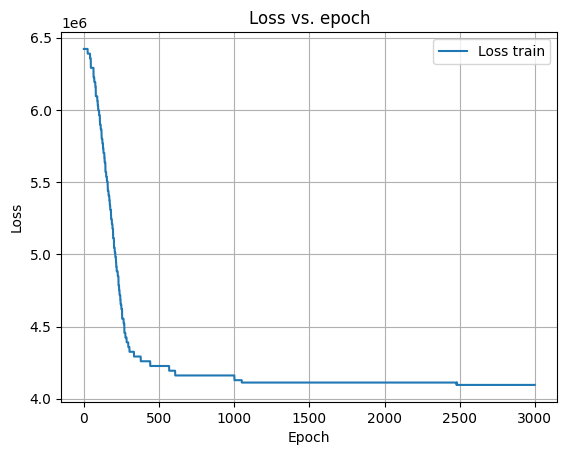

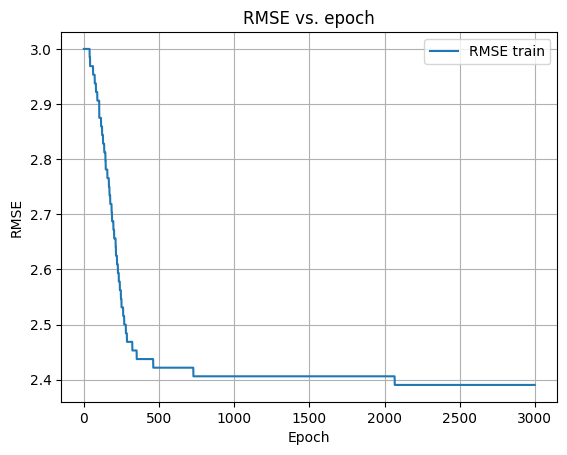

Final train Loss:  4096000.0  RMSE:  2.390625


In [11]:
#iterate for all versions of all_versions, which one is the best

def safe_check_unique(tensor):
    # Convert tensor to float32 if it's BFloat16
    if tensor.dtype == torch.bfloat16:
        tensor = tensor.to(torch.float32)
    # Perform the unique operation
    unique_values = torch.unique(tensor)
    return unique_values

def calculate_rmse(predictions1, actual1, mask1, predictions2, actual2, mask2, predictions3, actual3, mask3):
    # Check inputs do not contain NaN or Inf
    assert not torch.isnan(predictions1).any() and not torch.isinf(predictions1).any(), "predictions1 contains NaN or Inf"
    assert not torch.isnan(actual1).any() and not torch.isinf(actual1).any(), "actual1 contains NaN or Inf"
    assert not torch.isnan(predictions2).any() and not torch.isinf(predictions2).any(), "predictions2 contains NaN or Inf"
    assert not torch.isnan(actual3).any() and not torch.isinf(actual3).any(), "actual3 contains NaN or Inf"
    
    # Calculate the squared differences
    squared_diff1 = (predictions1 - actual1) ** 2
    squared_diff2 = (predictions2 - actual2) ** 2
    squared_diff3 = (predictions3 - actual3) ** 2
    
    # Apply the mask to the squared differences
    squared_diff1 = squared_diff1 * mask1
    squared_diff2 = squared_diff2 * mask2
    squared_diff3 = squared_diff3 * mask3

    # Verify masks are binary and valid
    unique_mask1 = safe_check_unique(mask1)
    unique_mask2 = safe_check_unique(mask2)
    unique_mask3 = safe_check_unique(mask3)

    assert unique_mask1.tolist() in [[0.0], [1.0], [0.0, 1.0]], "mask1 contains values other than 0 and 1"
    assert unique_mask2.tolist() in [[0.0], [1.0], [0.0, 1.0]], "mask2 contains values other than 0 and 1"
    assert unique_mask3.tolist() in [[0.0], [1.0], [0.0, 1.0]], "mask3 contains values other than 0 and 1"
    
    # Compute the mean of the squared differences where mask is 1
    rmse1 = torch.sqrt(squared_diff1.sum() / (mask1.sum() + 1e-8))
    rmse2 = torch.sqrt(squared_diff2.sum() / (mask2.sum() + 1e-8))
    rmse3 = torch.sqrt(squared_diff3.sum() / (mask3.sum() + 1e-8))
    rmse = rmse1 + rmse2 + rmse3

    # Assert final RMSE values do not contain NaN
    assert not torch.isnan(rmse).any(), "Final rmse calculation resulted in NaN"

    return rmse


def training_iteration(epoch, lr, lambda_reg, metadata, 
                plot_graph =True, epoch_print_result = True, epoch_print_mult=50, 
                save_checkpoint = True, epoch_save_mult = 100, checkpoint_folder="embedding_checkpoint_folder",
                save_version_key = ""):
    gc.collect()
    torch.cuda.empty_cache()

    #initialize tensor U and V
    UM_mask = metadata["user_merchant_mask"]
    UB_mask = metadata["user_brand_mask"]
    UC_mask = metadata["user_cat_mask"]
    UM_mask.requires_grad = False
    UB_mask.requires_grad = False
    UC_mask.requires_grad = False
    UM_gt = metadata["user_merchant_gt"]
    UB_gt = metadata["user_brand_gt"]
    UC_gt = metadata["user_cat_gt"]
    UM_gt.requires_grad = False
    UB_gt.requires_grad = False
    UC_gt.requires_grad = False
    
    user_embedding = metadata["user_embedding"].clone()
    merchant_embedding = metadata["merchant_embedding"].clone()
    brand_embedding = metadata["brand_embedding"].clone()
    cat_embedding = metadata["cat_embedding"].clone()

    user_embedding.requires_grad = True
    merchant_embedding.requires_grad = True
    brand_embedding.requires_grad = True
    cat_embedding.requires_grad = True
    
    #optimizer
    optimizer = torch.optim.Adam([user_embedding, merchant_embedding, brand_embedding, cat_embedding], lr=lr)
    loss_train_list = []
    #loss_test_list = []
    rmse_train_list = []
    #rmse_test_list = []
    counter = 0
    for iteration in tqdm(range(epoch)):

        UM_pred = user_embedding.mm(merchant_embedding.T)
        assert not torch.isnan(UM_pred).any(), "user_merchant_gt contains NaN"
        UB_pred = user_embedding.mm(brand_embedding.T)
        assert not torch.isnan(UB_pred).any(), "user_brand_gt contains NaN"
        UC_pred = user_embedding.mm(cat_embedding.T)
        assert not torch.isnan(UC_pred).any(), "user_cat_gt contains NaN"

        #calculate losses
        UM_term = UM_mask*(UM_gt - UM_pred)
        UM_term = 1/2 * torch.norm(input = UM_term, p="fro")**2
        assert not torch.isnan(UM_term).any(), "UM_term contains NaN"
        UB_term = UB_mask*(UB_gt - UB_pred)
        UB_term = 1/2 * torch.norm(input = UB_term, p="fro")**2
        assert not torch.isnan(UB_term).any(), "UB_term contains NaN"
        UC_term = UC_mask*(UC_gt - UC_pred)
        UC_term = 1/2 * torch.norm(input = UC_term, p="fro")**2
        assert not torch.isnan(UC_term).any(), "UC_term contains NaN"
        error_regularization = lambda_reg * (torch.norm(input = user_embedding, p="fro")**2 + torch.norm(input = merchant_embedding, p="fro")**2 + \
            torch.norm(input = brand_embedding, p="fro")**2 + torch.norm(input = cat_embedding, p="fro")**2  )
        assert not torch.isnan(error_regularization).any(), "error_regularization contains NaN"
        loss_train = UM_term + UB_term+ UC_term+ error_regularization
        loss_train_list.append(loss_train.item())

        
        #calculate rmse:
        rmse_error_train = calculate_rmse(UM_pred, UM_gt, UM_mask, UB_pred, UB_gt, UB_mask, UC_pred, UC_gt, UC_mask).detach()
        rmse_train_list.append(rmse_error_train.item())

        #update U and V
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        if epoch_print_result and not iteration % epoch_print_mult:
            #print("End of epoch: ", iter, " Loss: ", loss_train.item(), " RMSE: ", rmse_error_train.item(), " Test Loss: ", loss_test.item(), " Test RMSE: ", rmse_error_test.item())
            print("End of epoch: ", iteration, " Loss: ", loss_train.item(), " RMSE: ", rmse_error_train.item())
        # if iter > 0 and loss_test_list[-2] - loss_test_list[-1] < test_loss_not_change_limit:
        #     counter += 1
        #     if counter >= test_loss_not_changing_counter:
        #         print("Test loss not changing, break")
        #         break
        # else:
        #     counter = 0
        if save_checkpoint and not iteration % epoch_save_mult:
            user_embedding_path = os.path.join(checkpoint_folder, f"user_embedding_{save_version_key}_{iteration}.pt")
            merchant_embedding_path = os.path.join(checkpoint_folder, f"merchant_embedding_{save_version_key}_{iteration}.pt")
            brand_embedding_path = os.path.join(checkpoint_folder, f"brand_embedding_{save_version_key}_{iteration}.pt")
            cat_embedding_path = os.path.join(checkpoint_folder, f"cat_embedding_{save_version_key}_{iteration}.pt")
            torch.save(user_embedding, user_embedding_path)
            torch.save(merchant_embedding, merchant_embedding_path)
            torch.save(brand_embedding, brand_embedding_path)
            torch.save(cat_embedding, cat_embedding_path)
            

    if plot_graph:
        plt.plot(loss_train_list, label='Loss train')
        #plt.plot(loss_test_list, label='Loss test')
        plt.title('Loss vs. epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.show()

        #plot RMSE also
        plt.plot(rmse_train_list, label='RMSE train')
        #plt.plot(rmse_test_list, label='RMSE test')
        plt.title('RMSE vs. epoch')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.grid(True)
        plt.legend()
        plt.show()
    #print("Final train Loss: ", loss_train_list[-1], " RMSE: ", rmse_train_list[-1], " Test Loss: ", loss_test_list[-1], " Test RMSE: ", rmse_test_list[-1])
    print("Final train Loss: ", loss_train_list[-1], " RMSE: ", rmse_train_list[-1])
    return user_embedding, merchant_embedding, brand_embedding, cat_embedding, loss_train_list, rmse_train_list

metadata["user_embedding"], metadata["merchant_embedding"], \
    metadata["brand_embedding"], metadata["cat_embedding"], loss_train_list, rmse_train_list = training_iteration(epoch=3000, lr=0.001, lambda_reg=0.01, metadata=metadata, \
        plot_graph =True, epoch_print_result = True, epoch_print_mult=50, \
        save_checkpoint = True, epoch_save_mult = 100, checkpoint_folder="embedding_checkpoint_folder", \
        save_version_key = "version1")

In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()

: 

In [10]:
# Set the device to load tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize metadata dictionary
metadata = {}

# Load LabelEncoders using pickle
with open(user_encoder_path, 'rb') as f:
    metadata['user_encoder'] = pickle.load(f)
with open(merchant_encoder_path, 'rb') as f:
    metadata['merchant_encoder'] = pickle.load(f)
with open(brand_encoder_path, 'rb') as f:
    metadata['brand_encoder'] = pickle.load(f)
with open(cat_encoder_path, 'rb') as f:
    metadata['cat_encoder'] = pickle.load(f)

# Load PyTorch tensors and move them directly to the GPU (if CUDA is available)
metadata['user_embedding'] = torch.load(user_embedding_path, map_location=device)
metadata['merchant_embedding'] = torch.load(merchant_embedding_path, map_location=device)
metadata['brand_embedding'] = torch.load(brand_embedding_path, map_location=device)
metadata['cat_embedding'] = torch.load(cat_embedding_path, map_location=device)

metadata['user_merchant_mask'] = torch.load(user_merchant_mask_path, map_location=device)
metadata['user_brand_mask'] = torch.load(user_brand_mask_path, map_location=device)
metadata['user_cat_mask'] = torch.load(user_cat_mask_path, map_location=device)

metadata['user_merchant_gt'] = torch.load(user_merchant_gt_path, map_location=device)
metadata['user_brand_gt'] = torch.load(user_brand_gt_path, map_location=device)
metadata['user_cat_gt'] = torch.load(user_cat_gt_path, map_location=device)

# Load DataFrames from CSV
metadata['train_df_sampled_X'] = pd.read_csv(train_df_sampled_X_path)
metadata['train_df_sampled_y'] = pd.read_csv(train_df_sampled_y_path)
metadata['val_df_sampled_X'] = pd.read_csv(val_df_sampled_X_path)
metadata['val_df_sampled_y'] = pd.read_csv(val_df_sampled_y_path)
gc.collect()
torch.cuda.empty_cache()

In [23]:
from collections import Counter
def training_iteration(metadata, chosen_versioning, grouping_method,
    num_round, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", model="lightgbm", use_embedding=True, save_model = True):

    assert grouping_method in ["unique_average", "average", "unique_sum", "sum", "mostoccurence"]

    metadata['user_embedding'] = torch.load(os.path.join(checkpoint_folder, "user_embedding_"+chosen_versioning), map_location=device)
    metadata['merchant_embedding'] = torch.load(os.path.join(checkpoint_folder, "merchant_embedding_"+chosen_versioning), map_location=device)
    metadata['brand_embedding'] = torch.load(os.path.join(checkpoint_folder, "brand_embedding_"+chosen_versioning), map_location=device)
    metadata['cat_embedding'] = torch.load(os.path.join(checkpoint_folder, "cat_embedding_"+chosen_versioning), map_location=device)
    metadata['user_embedding'].requires_grad = False
    metadata['merchant_embedding'].requires_grad = False
    metadata['brand_embedding'].requires_grad = False
    metadata['cat_embedding'].requires_grad = False

    def get_averaged_embedding(ids, embedding_tensor):
        embeddings = [embedding_tensor[torch.tensor(id_list)].float().cpu() for id_list in ids]
        aggregated_embeddings = torch.stack(embeddings).mean(0).float().cpu().numpy()
        return aggregated_embeddings
    def get_summed_embedding(ids, embedding_tensor):
        embeddings = [embedding_tensor[torch.tensor(id_list)].float().cpu() for id_list in ids]
        aggregated_embeddings = torch.stack(embeddings).sum(0).float().cpu().numpy()
        return aggregated_embeddings
    def get_mostoccurence_embedding(ids, embedding_tensor):
        most_common_id, _ = Counter(ids).most_common(1)[0]
        aggregated_embeddings = [embedding_tensor[torch.tensor(most_common_id)].float().cpu()]
        aggregated_embeddings = torch.stack(aggregated_embeddings).float().cpu().numpy()
        aggregated_embeddings = aggregated_embeddings.flatten()
        return aggregated_embeddings
    
    chosen_embedding_method = None
    if "average" in grouping_method:
        chosen_embedding_method = get_averaged_embedding
    elif "sum" in grouping_method:
        chosen_embedding_method = get_summed_embedding
    elif "mostoccurence" in grouping_method:
        chosen_embedding_method = get_mostoccurence_embedding
    else:
        raise ValueError()

    gc.collect()
    torch.cuda.empty_cache()

    train_X = metadata["train_df_sampled_X"].copy()
    train_y = metadata["train_df_sampled_y"].copy()
    valid_X = metadata["val_df_sampled_X"].copy()
    valid_y = metadata["val_df_sampled_y"].copy()

    # Load user_info_log and filter for specific time_stamp
    user_info_log = pd.read_csv(user_log_format1_path, dtype={'time_stamp': str}).rename(columns={"seller_id": "merchant_id"})
    user_info_log = user_info_log[user_info_log["time_stamp"] == "1111"]
    user_info_log = user_info_log.drop(["time_stamp", "action_type", "item_id"],axis=1)

    train_X = pd.concat([train_X, train_y], axis=1)
    train_X = train_X.merge(user_info_log, on=["user_id", "merchant_id"], how="left")
    train_X = train_X.groupby(['user_id', 'merchant_id', "label"]).agg({
        'cat_id': lambda x: list(set(x)) if ("unique" in grouping_method) else list(x),
        'brand_id': lambda x: list(set(x)) if ("unique" in grouping_method) else list(x)
    }).reset_index()
    train_y = train_X["label"]
    train_X = train_X.drop("label", axis=1)

    train_X['encoded_user_id'] = metadata['user_encoder'].transform(train_X['user_id'])
    train_X['encoded_merchant_id'] = metadata['merchant_encoder'].transform(train_X['merchant_id'])
    train_X['encoded_cat_id'] = train_X['cat_id'].apply(lambda ids: [metadata['cat_encoder'].transform([id])[0] for id in ids])
    train_X['encoded_brand_id'] = train_X['brand_id'].apply(lambda ids: [metadata['brand_encoder'].transform([id])[0] for id in ids])

    # Then, fetch embeddings using the encoded indices
    train_X['user_embeddings'] = train_X['encoded_user_id'].apply(lambda x: metadata['user_embedding'][x].float().cpu().numpy())
    train_X['merchant_embeddings'] = train_X['encoded_merchant_id'].apply(lambda x: metadata['merchant_embedding'][x].float().cpu().numpy())
    train_X['aggr_cat_embeddings'] = train_X['encoded_cat_id'].apply(lambda x: chosen_embedding_method(x, metadata['cat_embedding']))
    train_X['aggr_brand_embeddings'] = train_X['encoded_brand_id'].apply(lambda x: chosen_embedding_method(x, metadata['brand_embedding']))

    valid_X = pd.concat([valid_X, valid_y], axis=1)
    valid_X = valid_X.merge(user_info_log, on=["user_id", "merchant_id"], how="left")
    valid_X = valid_X.groupby(['user_id', 'merchant_id', "label"]).agg({
        'cat_id': lambda x: list(set(x)) if ("unique" in grouping_method) else list(x),
        'brand_id': lambda x: list(set(x)) if ("unique" in grouping_method) else list(x)
    }).reset_index()
    valid_y = valid_X["label"]
    valid_X = valid_X.drop("label", axis=1)

    valid_X['encoded_user_id'] = metadata['user_encoder'].transform(valid_X['user_id'])
    valid_X['encoded_merchant_id'] = metadata['merchant_encoder'].transform(valid_X['merchant_id'])
    valid_X['encoded_cat_id'] = valid_X['cat_id'].apply(lambda ids: [metadata['cat_encoder'].transform([id])[0] for id in ids])
    valid_X['encoded_brand_id'] = valid_X['brand_id'].apply(lambda ids: [metadata['brand_encoder'].transform([id])[0] for id in ids])

    # Then, fetch embeddings using the encoded indices
    valid_X['user_embeddings'] = valid_X['encoded_user_id'].apply(lambda x: metadata['user_embedding'][x].float().cpu().numpy())
    valid_X['merchant_embeddings'] = valid_X['encoded_merchant_id'].apply(lambda x: metadata['merchant_embedding'][x].float().cpu().numpy())
    valid_X['aggr_cat_embeddings'] = valid_X['encoded_cat_id'].apply(lambda x: chosen_embedding_method(x, metadata['cat_embedding']))
    valid_X['aggr_brand_embeddings'] = valid_X['encoded_brand_id'].apply(lambda x: chosen_embedding_method(x, metadata['brand_embedding']))
    del user_info_log
    gc.collect()
    torch.cuda.empty_cache()
    # =============== BEGIN TRAINING
    # Define the function to expand embedding arrays into separate DataFrame columns
    def expand_embeddings(df, column_names):
        """
        Expand multiple columns containing embedded lists into multiple distinct columns for each embedding,
        and concatenate them into a single DataFrame.
        
        Args:
        df (pd.DataFrame): The original DataFrame containing embedding columns.
        column_names (list of str): A list of column names to expand.

        Returns:
        pd.DataFrame: A new DataFrame with expanded embedding columns.
        """
        expanded_df = pd.DataFrame(index=df.index)
        for column_name in column_names:
            embeddings = np.stack(df[column_name].to_numpy())
            col_names = [f'{column_name}_{i}' for i in range(embeddings.shape[1])]
            embeddings_df = pd.DataFrame(embeddings, columns=col_names, index=df.index)
            expanded_df = pd.concat([expanded_df, embeddings_df], axis=1)
        return expanded_df

    
    # Configure parameters for LightGBM
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
    }
    if use_embedding:
        # Assuming 'metadata' contains all your embeddings and the 'train_X', 'val_X' have been prepared
        # Expand embeddings into separate columns for training and validation sets
        train_X = expand_embeddings(train_X, 
                                            ['user_embeddings', 'merchant_embeddings', 'aggr_cat_embeddings', 'aggr_brand_embeddings'])
        valid_X = expand_embeddings(valid_X, 
                                        ['user_embeddings', 'merchant_embeddings', 'aggr_cat_embeddings', 'aggr_brand_embeddings'])

    else:
        train_X = metadata["train_df_sampled_X"]
        train_y = metadata["train_df_sampled_y"]
        valid_X= metadata["val_df_sampled_X"]
        valid_y = metadata["val_df_sampled_y"]
    
    # Free up memory
    gc.collect()
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y, reference=train_data)


    # Train the model
    lgb_model = lgb.train(params, train_data, 
        num_boost_round=num_round, valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)])

    # Save the model
    if save_model: 
        lgb_model.save_model(save_model_path)

    # Predictions
    y_pred_valid = lgb_model.predict(valid_X, num_iteration=lgb_model.best_iteration)
    # Convert probabilities to binary output if needed, for example:
    y_pred_binary_valid = (y_pred_valid >= 0.5).astype(int)
    accuracy_valid = accuracy_score(valid_y, y_pred_binary_valid)
    auc_valid = roc_auc_score(valid_y, y_pred_valid)
    return lgb_model, accuracy_valid, auc_valid

In [13]:
#ablate and get all the versions of the embeddings
checkpoint_folder="embedding_checkpoint_folder"
all_versions = os.listdir(checkpoint_folder)
all_versions = ["_".join(i.split("_")[2:]) for i in all_versions]
all_versions = list(set(all_versions))
# Sort the files based on the numeric value
all_versions = sorted(all_versions, key=lambda x: int(x.split("_")[1][:-3]))
print(all_versions)
for version_name in all_versions:
    model, accuracy_valid, auc_valid = training_iteration(metadata, version_name, grouping_method = "average", num_round=1000, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", use_embedding=True, save_model = True)
    print("version_name", version_name)
    print("validation_score: ", auc_valid)

['version1_0.pt', 'version1_100.pt', 'version1_200.pt', 'version1_300.pt', 'version1_400.pt', 'version1_500.pt', 'version1_600.pt', 'version1_700.pt', 'version1_800.pt', 'version1_900.pt', 'version1_1000.pt', 'version1_1100.pt', 'version1_1200.pt', 'version1_1300.pt', 'version1_1400.pt', 'version1_1500.pt', 'version1_1600.pt', 'version1_1700.pt', 'version1_1800.pt', 'version1_1900.pt', 'version1_2000.pt', 'version1_2100.pt', 'version1_2200.pt', 'version1_2300.pt', 'version1_2400.pt', 'version1_2500.pt', 'version1_2600.pt', 'version1_2700.pt', 'version1_2800.pt', 'version1_2900.pt']


[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20239
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.222724
version_name version1_0.pt
validation_score:  0.6393264104663181
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19659
[LightGBM] [Info] Number of data point

KeyboardInterrupt: 

In [24]:
model, accuracy_valid, auc_valid = training_iteration(metadata, "version1_1200.pt", grouping_method = "mostoccurence", num_round=1000, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", use_embedding=True, save_model = True)
print("Grouping Method", "mostoccurence")
print("validation_score: ", auc_valid)
model, accuracy_valid, auc_valid = training_iteration(metadata, "version1_1200.pt", grouping_method = "unique_average", num_round=1000, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", use_embedding=True, save_model = True)
print("Grouping Method", "unique_average")
print("validation_score: ", auc_valid)
model, accuracy_valid, auc_valid = training_iteration(metadata, "version1_1200.pt", grouping_method = "unique_sum", num_round=1000, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", use_embedding=True, save_model = True)
print("Grouping Method", "unique_sum")
print("validation_score: ", auc_valid)
model, accuracy_valid, auc_valid = training_iteration(metadata, "version1_1200.pt", grouping_method = "sum", num_round=1000, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", use_embedding=True, save_model = True)
print("Grouping Method", "sum")
print("validation_score: ", auc_valid)
model, accuracy_valid, auc_valid = training_iteration(metadata, "version1_1200.pt", grouping_method = "average", num_round=1000, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", use_embedding=True, save_model = True)
print("Grouping Method", "sum")
print("validation_score: ", auc_valid)

[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18944
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.222938
Grouping Method mostoccurence
validation_score:  0.6389982884821452
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19964
[LightGBM] [Info] Number of data po

In [25]:
print(auc_valid)
print(accuracy_valid)

0.646208089443319
0.9387817686970522


In [68]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 74.0 MB/s eta 0:00:00


In [ ]:
import optuna
import logging

logging.basicConfig(filename='optuna_output.log', level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
def trial_maximization(trial):
    versions = trial.suggest_int("version_number", 0, 2000, step = 50)
    grouping_method = trial.suggest_categorical("grouping_method", ["unique_average", "average", "unique_sum", "sum", "mostoccurence"])
    num_round = trial.suggest_int("num_round", 500, 3000)
    _, _, auc_valid = training_iteration(metadata, f"version1_{versions}.pt", grouping_method = "average", num_round=1000, checkpoint_folder = "embedding_checkpoint_folder", 
    save_model_path = "lightgbm.txt", use_embedding=True, save_model = False)
    logging.info(f'Trial {trial.number}, Params: {{versions: {versions}, grouping_method: {grouping_method}}}, num_round: {num_round}. AUC Result: {auc_valid}')
    return auc_valid
logging.info('Trial begins')
study = optuna.create_study(direction="maximize")
study.optimize(trial_maximization, n_trials=300)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best AUC:", study.best_value)
logging.info("Best hyperparameters:", study.best_params)
logging.info("Best AUC:", study.best_value)

[I 2024-12-10 16:13:14,772] A new study created in memory with name: no-name-8443874a-97f8-4901-94ea-53528daa5f56


[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19852
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:17:05,370] Trial 0 finished with value: 0.6293152597457451 and parameters: {'version_number': 1650, 'grouping_method': 'mostoccurence', 'num_round': 2588}. Best is trial 0 with value: 0.6293152597457451.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.223731
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19849
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:21:03,988] Trial 1 finished with value: 0.6359568500903885 and parameters: {'version_number': 950, 'grouping_method': 'mostoccurence', 'num_round': 948}. Best is trial 1 with value: 0.6359568500903885.


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.223248
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19865
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:24:52,256] Trial 2 finished with value: 0.6331618743654764 and parameters: {'version_number': 1750, 'grouping_method': 'mostoccurence', 'num_round': 2779}. Best is trial 1 with value: 0.6359568500903885.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.223139
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19830
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:28:31,982] Trial 3 finished with value: 0.6389596091001758 and parameters: {'version_number': 1000, 'grouping_method': 'mostoccurence', 'num_round': 1375}. Best is trial 3 with value: 0.6389596091001758.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.222806
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19834
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:32:32,505] Trial 4 finished with value: 0.6301410811898402 and parameters: {'version_number': 1950, 'grouping_method': 'average', 'num_round': 1263}. Best is trial 3 with value: 0.6389596091001758.


Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.223207
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19835
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:36:40,186] Trial 5 finished with value: 0.6369824552780845 and parameters: {'version_number': 1150, 'grouping_method': 'average', 'num_round': 1816}. Best is trial 3 with value: 0.6389596091001758.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.22309
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19835
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:40:58,118] Trial 6 finished with value: 0.6404562528766351 and parameters: {'version_number': 1400, 'grouping_method': 'unique_average', 'num_round': 1478}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.222756
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19830
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:44:53,005] Trial 7 finished with value: 0.6389596091001758 and parameters: {'version_number': 1000, 'grouping_method': 'unique_average', 'num_round': 2107}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.222806
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19863
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:48:44,543] Trial 8 finished with value: 0.6366670685636202 and parameters: {'version_number': 600, 'grouping_method': 'unique_average', 'num_round': 2086}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.223016
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19828
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:52:09,996] Trial 9 finished with value: 0.637201809099459 and parameters: {'version_number': 550, 'grouping_method': 'unique_average', 'num_round': 1129}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.223149
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20238
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:56:02,249] Trial 10 finished with value: 0.6368557809420976 and parameters: {'version_number': 0, 'grouping_method': 'unique_sum', 'num_round': 523}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.223299
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19860
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 16:59:57,039] Trial 11 finished with value: 0.6312582779253106 and parameters: {'version_number': 1450, 'grouping_method': 'sum', 'num_round': 1548}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.223009
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19846
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 17:03:52,444] Trial 12 finished with value: 0.6368803939306904 and parameters: {'version_number': 1350, 'grouping_method': 'unique_sum', 'num_round': 1439}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.222933
[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19830
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds


[I 2024-12-10 17:07:37,206] Trial 13 finished with value: 0.636027450841859 and parameters: {'version_number': 650, 'grouping_method': 'sum', 'num_round': 726}. Best is trial 6 with value: 0.6404562528766351.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.223136


[LightGBM] [Info] Number of positive: 6381, number of negative: 97964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 104345, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731275
[LightGBM] [Info] Start training from score -2.731275
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.228212
Accuracy: 0.9388584352359413
AUC Score: 0.571221618267522


In [ ]:
#Train lightgbm
#split already included in metadata
# Convert the datasets to LightGBM dataset format
train_X = metadata["train_df_sampled_X"]
train_y = metadata["train_df_sampled_y"]
valid_X= metadata["val_df_sampled_X"]
valid_y = metadata["val_df_sampled_y"]
train_data = lgb.Dataset(metadata["train_df_sampled_X"], label=metadata["train_df_sampled_y"])
valid_data = lgb.Dataset(metadata["val_df_sampled_X"], label=metadata["val_df_sampled_y"], reference=train_data)

# Define parameters for the LightGBM model
params = {
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'objective': 'binary',    # Binary classification
    'metric': 'binary_logloss'  # Logarithmic loss for binary classification
}

# Train the model
print("Starting training...")
model = lgb.train(params,
                  train_data,
                  valid_sets=[valid_data],
                  num_boost_round=1000,
                  early_stopping_rounds=100)

y_pred_valid = model.predict(valid_X, num_iteration=model.best_iteration)
# Convert probabilities to binary output if needed, for example:
y_pred_binary_valid = (y_pred_valid >= 0.5).astype(int)

# Evaluate the model
accuracy_valid = accuracy_score(valid_y, y_pred_binary_valid)
auc_valid = roc_auc_score(valid_y, y_pred_valid)

print(f"Accuracy: {accuracy}")
print(f"AUC Score: {auc_score}")

In [39]:
#how many users in train appear in test set
print("Amount of user id duplicated in train and test: ", train_format1['user_id'].isin(test_format1['user_id']).sum())
print("Ratio toward the whole test: ", train_format1['user_id'].isin(test_format1['user_id']).sum() / len(test_format1['user_id']))

#how many merchants in train appear in test set
print("Amount of merchant id duplicated in train and test: ", train_format1['merchant_id'].isin(test_format1['merchant_id']).sum())
print("Ratio toward the whole test: ", train_format1['merchant_id'].isin(test_format1['merchant_id']).sum() / len(test_format1['merchant_id']))

Amount of user id duplicated in train and test:  0
Ratio toward the whole test:  0.0
Amount of merchant id duplicated in train and test:  260863
Ratio toward the whole test:  0.9976518011144384


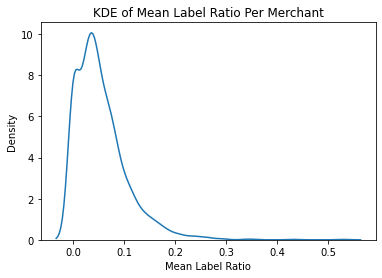

In [46]:
#for each merchant, how many users get the label 1 (ratio)
merchant_ratios = train_format1['label'].groupby(train_format1['merchant_id']).mean()

sns.kdeplot(merchant_ratios, bw_adjust=1)  # bw_adjust adjusts the bandwidth; tweak as needed
plt.title("KDE of Mean Label Ratio Per Merchant")
plt.xlabel("Mean Label Ratio")
plt.ylabel("Density")
plt.show()

In [27]:
# class balance or imbalance
print("Train label 0 ratio: ", train_format1[train_format1['label'] == 0].shape[0] / len(train_format1['label']))

Train label 0 ratio:  0.9388493621197253


In [35]:
def training_iteration_lightgbm(train_data, val_data, train_target, val_target, params):
    lgbm_train_data = lgb.Dataset(train_data, label=train_target)
    lgbm_val_data = lgb.Dataset(val_data, label=val_target, reference=train_data)
    model = lgb.train(params, lgbm_train_data, num_boost_round=1000, valid_sets=[lgbm_val_data], early_stopping_rounds=50, verbose_eval=50)
    return model

In [ ]:
#lightgbm baseline
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
}
baseline_train_data = train_format1.drop(['label'], axis=1)

#preprocessing null in age range
baseline_user_info = 
baseline_train_data = baseline_train_data.merge(user_info_format1, on='user_id', how='left')
baseline_train_target = train_format1['label']

baseline_train_data.join(other, lsuffix='_caller', rsuffix='_other')